In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import njit
from scipy.stats import norm
from tqdm import tqdm

# Simulation based trees 

### Black-Scholes approach

In [2]:
def simulate_trajectories_bs(
    mu: float,
    T : float ,
    m : int ,
    n: int ,
    sigma: float,
    S0, 
):
    """
    Simulates multiple trajectories of the underlying asset price using a geometric Brownian motion (GBM) model.

    Parameters:
    mu (float): The drift rate, representing the expected return of the asset.
    T (float): The total time period for the simulation (in years). Default is `T`.
    m (int): The number of trajectories (simulated paths) to generate. Default is `M`.
    n (int): The number of time steps within each trajectory. Default is `N`.
    sigma (float): The volatility of the asset. Default is `sigma`.

    Returns:
    np.ndarray: A 2D array of shape (m, n+1) where each row represents a simulated trajectory of the asset price.
    """
    dt = T/n
    dW = np.random.normal(0, np.sqrt(dt), size=(m,n+1))

    dW[:, 0] = 0

    W = dW.cumsum(axis=1)
    t = np.linspace(0,T, n+1)
    trend = mu - sigma**2/2

    St = S0*np.exp(trend*t + sigma*W)

    return St

In [3]:
def possible_prices(St, t):
    quantiles = np.linspace(0,1,t+1)
    return np.quantile(St[:, t], quantiles)

In [4]:
kappa = 5.0
K = 10
r = 0.1
eta = 0.9
theta = 0.16
rho = 0.1
T = 0.25
v0 = 0.25**2
S0 = 10
N = 500
M = 100_000
dt = T/N

In [5]:
g = lambda x, strike : np.maximum(strike-x, 0)

In [9]:
N = 300
option_prices = []

for n in range(2,N, 10):
    memo = {}
    # brownian = np.random.multivariate_normal(
    #     [0,0], 
    #     [[1, rho],[rho,1]], 
    #     size=(M,n)
    # )
    # dW, dW_hat= brownian[:,:,0]*np.sqrt(dt), brownian[:,:,1]*np.sqrt(dt)
    St= simulate_trajectories_bs(r, T, M, n, np.sqrt(theta), S0)
    for t in tqdm(range(n-1, -1, -1)):
        
        prices = possible_prices(St, t)
        var = theta
        log_prices = np.log(prices)

        memo[t] = np.zeros_like(prices)
        stopping_values = g(prices, K)

        if t == n-1:
            memo[t] = stopping_values
            continue

        future_prices = possible_prices(St, t+1)
        log_future_prices = np.log(future_prices)
        
        # probabilities[i][j] = proba(S_{t+1} in (possible_prices[j], possible_prices[j+1]) | S_t = possible_prices[i])
        # matrix = np.tile(log_prices.reshape(t+1, 1), (1, t + 2))
        probabilities = np.ones((t+1, t+2))
        # probabilities[:, 0:-1] = np.diff(norm.cdf((log_future_prices-matrix- (r-var/2)*dt)/np.sqrt(dt*var)), axis = 1)  
        # probabilities[:, -1] =1-norm.cdf((log_future_prices[-1]-matrix[:, -1]- (r-var/2)*dt)/np.sqrt(dt*var))

        for i, log_price in enumerate(log_prices):
            probabilities[:,i] = np.diff(norm.cdf(1/np.sqrt(var*dt)*(log_future_prices - log_price - r*dt)))

        if (probabilities.sum(axis = 1) == 0).any():
            break
        
        
        probabilities = probabilities / probabilities.sum(axis = 1, keepdims = True)

        continuation_values = probabilities @ (memo[t+1]*np.exp(-r*dt))

        memo[t]= continuation_values
        # memo[t]= np.maximum(continuation_values, stopping_values)


    option_prices.append(memo[0])

100%|██████████| 2/2 [00:00<00:00, 301.12it/s]


  2%|▏         | 4/162 [00:00<00:07, 21.61it/s]


KeyboardInterrupt: 

In [7]:
def black_scholes(S, K, T, r, sigma, option_type='call'):
    """
    Compute the Black-Scholes option price for a European call or put.
    
    Parameters:
    S (float): Current stock price
    K (float): Strike price
    T (float): Time to maturity (in years)
    r (float): Risk-free interest rate (annual)
    sigma (float): Volatility of the underlying asset (annual)
    option_type (str): 'call' for a call option, 'put' for a put option
    
    Returns:
    float: Black-Scholes option price
    """
    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        # Call option price
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        # Put option price
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be either 'call' or 'put'")
    
    return price

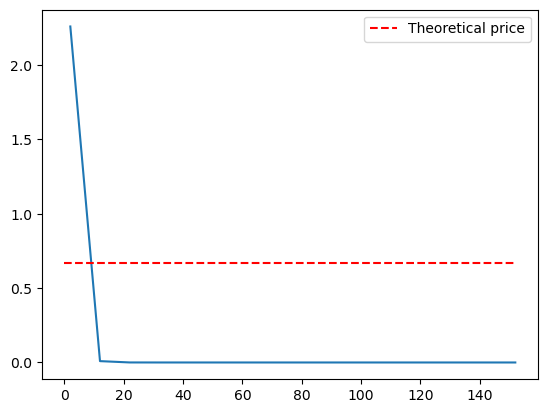

In [10]:
bs_price = black_scholes(S0, K, T, r, np.sqrt(theta), 'put')
ns = np.arange(2,len(option_prices)*10+2, 10)

plt.plot(ns, option_prices)
plt.hlines(bs_price, 0, ns[-1], linestyles = 'dashed', color = 'red', label = 'Theoretical price')

plt.legend()

0.6693902303919748

In [228]:
params = {
    'kappa': 5.0,
    'K': 10,
    'r': 0.1,
    'eta': 0.9 ,
    'theta': 0.16,
    'rho': 0.1,
    'T' : 0.25,
    'v0' : 0.25**2,
    'S0' : 10,
    'N': 500, 
    'M': 1000
}

params['h'] = params['T']/params['N']
params['x0'] = np.log(params['S0'])
params['y0'] = params['v0']/params['eta'] - params['rho'] * params['x0']
params['A'] = (params['kappa']*params['theta']/params['eta'] - np.abs(params['rho'])*params['r'])*np.sqrt(params['h']/(params['eta']*(1-params['rho']**2)))



Text(0.5, 1.0, 'Risk free')

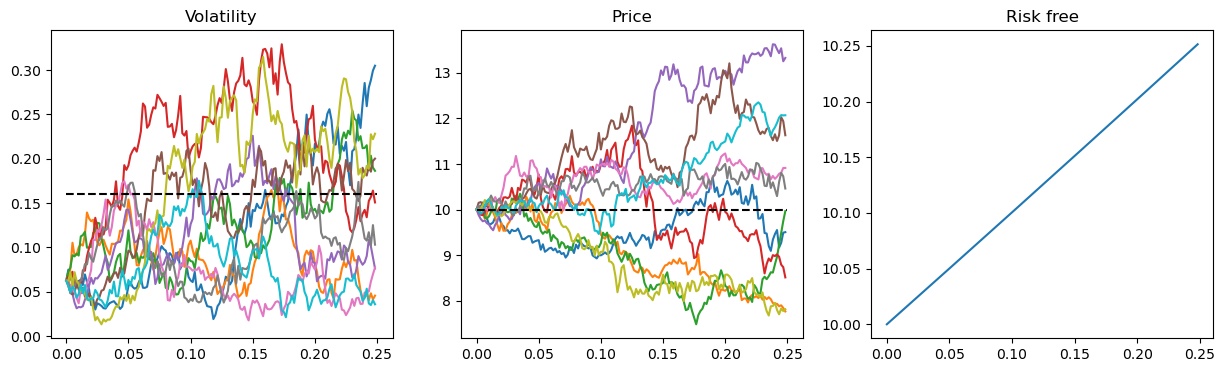

In [10]:
dt = T/N

brownian = np.random.multivariate_normal(
    [0,0], 
    [[1, rho],[rho,1]], 
    size=(M,N)
)
dW, dW_hat= brownian[:,:,0]*np.sqrt(dt), brownian[:,:,1]*np.sqrt(dt)


@njit()
def generate_trajectories(dW, dW_hat, kappa, theta, v0, S0, eta, dt,r, N):
    vt = np.zeros_like(dW_hat)
    St = np.zeros_like(vt)
    vt[:,0] = v0
    St[:, 0] = S0

    for t in range(1,N):
        vt[:, t] = vt[:,t-1 ] + kappa*(theta - vt[:, t-1]) * dt + eta* np.sqrt(vt[:, t-1])* dW_hat[:, t]
        # use abs or (vt)_+?
        # vt[:, t] = np.maximum(0, vt[:,t])
        vt[:, t] = np.abs(vt[:,t])

        # use r or r-v_t/2?  
        dSt = St[:,t-1]*((r-1/2*vt[:, -1] )*dt + np.sqrt(vt[:, t-1])* dW[:, t])
        St[:, t] = St[:, t-1] + dSt

    return St, vt

St, vt = generate_trajectories(dW, dW_hat, kappa, theta, v0, S0, eta, dt,r, N)
fig, ax = plt.subplots(1,3, figsize = (15,4))

t = np.arange(0,T, dt)
ax[0].plot(t, vt[0:10].T)
ax[0].set_title("Volatility")
ax[0].hlines(theta, 0, T, linestyles = 'dashed', color = 'black')
ax[1].plot(t, St[0:10].T)
ax[1].set_title("Price")
ax[1].hlines(S0, 0, T, linestyles = 'dashed', color = 'black')

ax[2].plot(t, S0* np.exp(r*t).T)
ax[2].set_title("Risk free")

In [152]:
def possible_prices(St, t):
    quantiles = np.linspace(0,1,t+1)
    return np.quantile(St[:, t], quantiles)

In [153]:
g = lambda s, K: np.maximum(K - s, 0)

In [203]:
params = {
    'kappa': 5.0,
    'K': 10,
    'r': 0.1,
    'eta': 0.9 ,
    'theta': 0.16,
    'rho': 0.1,
    'T' : 0.25,
    'v0' : 0.25**2,
    'S0' : 10,
    'N': 500, 
    'M': 1000
}

params['h'] = params['T']/params['N']
params['x0'] = np.log(params['S0'])
params['y0'] = params['v0']/params['eta'] - params['rho'] * params['x0']
params['A'] = (params['kappa']*params['theta']/params['eta'] - np.abs(params['rho'])*params['r'])*np.sqrt(params['h']/(params['eta']*(1-params['rho']**2)))

kappa = 5.0
K = 10
r = 0.1
eta = 0.9
theta = 0.16
rho = 0.1
T = 0.25
v0 = 0.25**2
S0 = 10
N = 200
M = 1000
dt = T/N

In [204]:
brownian = np.random.multivariate_normal(
    [0,0], 
    [[1, rho],[rho,1]], 
    size=(M,N)
)
dW, dW_hat= brownian[:,:,0]*np.sqrt(dt), brownian[:,:,1]*np.sqrt(dt)
St, vt = generate_trajectories(dW, dW_hat, kappa, theta, v0, S0, eta, dt,r, N)

In [225]:
N = 200

option_prices = []

for n in range(2,N, 10):
    memo = {}
    brownian = np.random.multivariate_normal(
        [0,0], 
        [[1, rho],[rho,1]], 
        size=(M,n)
    )
    dW, dW_hat= brownian[:,:,0]*np.sqrt(dt), brownian[:,:,1]*np.sqrt(dt)
    St, vt = generate_trajectories(dW, dW_hat, kappa, theta, v0, S0, eta, dt,r, n)
    for t in tqdm(range(n-1, -1, -1)):
        
        prices = possible_prices(St, t)
        var = vt[:,t].mean()
        log_prices = np.log(prices)

        memo[t] = np.zeros_like(prices)
        stopping_values = g(prices, K)

        if t == n-1:
            memo[t] = stopping_values
            continue

        future_prices = possible_prices(St, t+1)
        log_future_prices = np.log(future_prices)
        
        # probabilities[i][j] = proba(S_{t+1} in (possible_prices[j], possible_prices[j+1]) | S_t = possible_prices[i])
        matrix = np.tile(log_prices.reshape(t+1, 1), (1, t + 2))
        probabilities = np.ones((t+1, t+2))
        # probabilities[:, 0:-1] = np.diff(norm.cdf((log_future_prices-matrix- (r-var/2)*dt)/np.sqrt(dt*var)), axis = 1)  
        # probabilities[:, -1] =norm.cdf((log_future_prices[-1]-matrix[:, -1]- (r-var/2)*dt)/np.sqrt(dt*var))

        for i, price in enumerate(log_prices):
            probabilities[:,i] = np.diff(norm.cdf(1/np.sqrt(var*dt)*(log_future_prices - price - r*dt)))

        if (probabilities.sum(axis = 1) == 0).any():
            break
        
        
        probabilities = probabilities / probabilities.sum(axis = 1, keepdims = True)

        continuation_values = probabilities @ (memo[t+1]*np.exp(-r*dt))

        memo[t]= np.maximum(continuation_values, stopping_values)


    option_prices.append(memo[0])

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 192/192 [00:01<00:00, 125.38it/s]


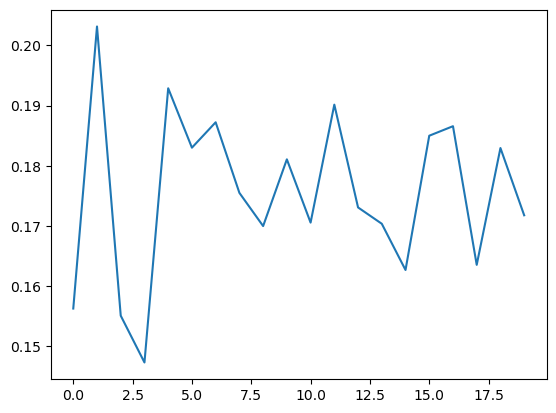

In [226]:
plt.plot(option_prices)

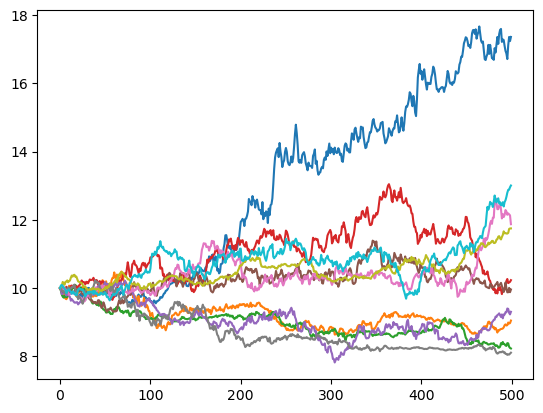

In [174]:
plt.plot(St[0:10].T)